In [1]:
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
APPL = pd.read_csv("/content/drive/MyDrive/Datasets/preprocessed_AAPL")
TESL = pd.read_csv("/content/drive/MyDrive/Datasets/preprocessed_TSLA")
GOOG = pd.read_csv("/content/drive/MyDrive/Datasets/preprocessed_GOOG")

### Data Proprocessing

In [3]:
def get_train_test_xy_data(dataset, Date):
  train_data = []
  train_X_data = []
  train_Y_data = []
  train_dataset = dataset['Adj Close'][dataset['Date'] < Date].to_numpy()

  for i in range(0, len(train_dataset), 5):
    try:
      train_data.append(train_dataset[i : i + 5])
    except:
      pass

  if len(train_data[-1]) < 5:
    train_data.pop(-1)

  train_X_data = train_data[0 : -1]
  train_X_data = np.array(train_X_data)
  train_X_data = train_X_data.reshape((-1, 5, 1))
  train_Y_data = train_data[1 : len(train_data)]
  train_Y_data = np.array(train_Y_data)
  train_Y_data = train_Y_data.reshape((-1, 5, 1))
  test_data = []
  test_X_data = []
  test_Y_data = []

  test_dataset = dataset['Adj Close'][dataset['Date'] >= Date].to_numpy()

  for i in range(0, len(test_dataset), 5):
    try:
      test_data.append(test_dataset[i : i + 5])
    except:
      pass

  if len(test_data[-1]) < 5:
    test_data.pop(-1)

  test_X_data = test_data[0 : -1]
  test_X_data = np.array(test_X_data)
  test_X_data = test_X_data.reshape((-1, 5, 1))
  test_Y_data = test_data[1 : len(test_data)]
  test_Y_data = np.array(test_Y_data)
  test_Y_data = test_Y_data.reshape((-1, 5, 1))

  return train_X_data, train_Y_data, test_X_data, test_Y_data

###LSTM Model

In [4]:
def LSTM_Model():
  lstm_model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return lstm_model

In [5]:
model = LSTM_Model()

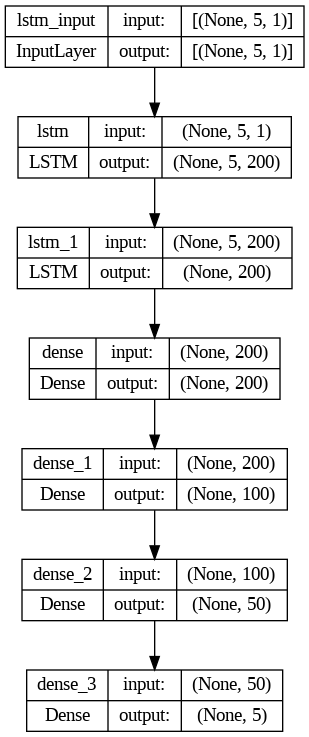

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548005 (2.09 MB)
Trainable params: 548005 

### Custom Learning Rate

In [8]:
def scheduler(epoch):

  if epoch <= 150:
    learning_rate = (10 ** -5) * (epoch / 150)
  elif epoch <= 400:
    initial_learning_rate = (10 ** -5)
    k = 0.01
    learning_rate = initial_learning_rate * math.exp(-k * (epoch - 150))
  else:
    learning_rate = (10 ** -6)

  return learning_rate

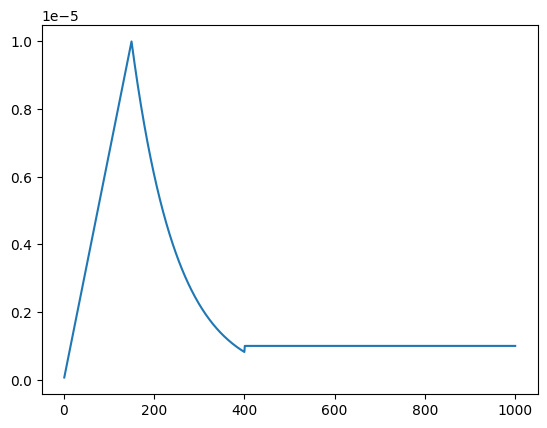

In [9]:
epochs = [i for i in range(1, 1001, 1)]
learning_rate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, learning_rate)

In [10]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple

In [11]:
APPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.059303,115127600.0
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.029022,84472400.0
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.166470,88774400.0
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.469332,127007600.0
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,27.720936,134247600.0


In [12]:
APPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [13]:
# Change datatype of Date column
APPL["Date"] = pd.to_datetime(APPL["Date"])

###Divide the data into training and test set

    Training Period: 2017-01-01 - 2023-07-10

    Testing Period:  2023-07-11 - 2023-10-10

In [14]:
divide_by_date = '2023-07-01'
APPL_Train_X, APPL_Train_Y, APPL_Test_X, APPL_Test_Y = get_train_test_xy_data(APPL, divide_by_date)

###Model Fitting

In [15]:
APPL_model=LSTM_Model()

In [16]:
APPL_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [17]:
APPL_hist = APPL_model.fit(APPL_Train_X, APPL_Train_Y, epochs = 1000, validation_data = (APPL_Test_X, APPL_Test_Y), callbacks=[callback])

Epoch 1/1000
11/11 [==============================] - 5s 77ms/step - loss: 10760.5996 - root_mean_squared_error: 103.7333 - val_loss: 32443.7617 - val_root_mean_squared_error: 180.1215 - lr: 0.0000e+00
Epoch 2/1000
11/11 [==============================] - 0s 33ms/step - loss: 10760.3682 - root_mean_squared_error: 103.7322 - val_loss: 32441.8750 - val_root_mean_squared_error: 180.1163 - lr: 6.6667e-08
Epoch 3/1000
11/11 [==============================] - 0s 35ms/step - loss: 10759.5889 - root_mean_squared_error: 103.7284 - val_loss: 32438.1328 - val_root_mean_squared_error: 180.1059 - lr: 1.3333e-07
Epoch 4/1000
11/11 [==============================] - 0s 34ms/step - loss: 10758.2686 - root_mean_squared_error: 103.7221 - val_loss: 32432.3984 - val_root_mean_squared_error: 180.0900 - lr: 2.0000e-07
Epoch 5/1000
11/11 [==============================] - 0s 32ms/step - loss: 10756.4541 - root_mean_squared_error: 103.7133 - val_loss: 32424.9043 - val_root_mean_squared_error: 180.0692 - lr: 2

In [18]:
APPL_dict_history = APPL_hist.history

data_loss = APPL_dict_history["loss"]
root_mean_squared_error = APPL_dict_history["root_mean_squared_error"]
value_loss = APPL_dict_history["val_loss"]
value_root_mean_squared_error = APPL_dict_history["val_root_mean_squared_error"]

epochs = range(1, len(data_loss) + 1)

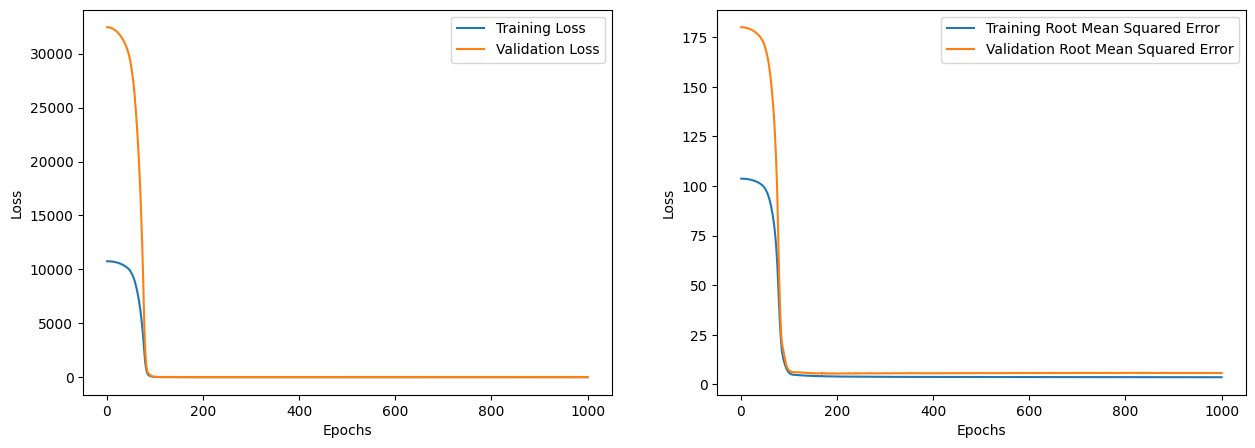

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, data_loss, label = 'Training Loss')
ax1.plot(epochs, value_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, value_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Forecasting the final stock price of Apple

In [48]:
APPL_prediction = APPL_model.predict(APPL_Test_X)

1/1 [==============================] - 0s 37ms/step


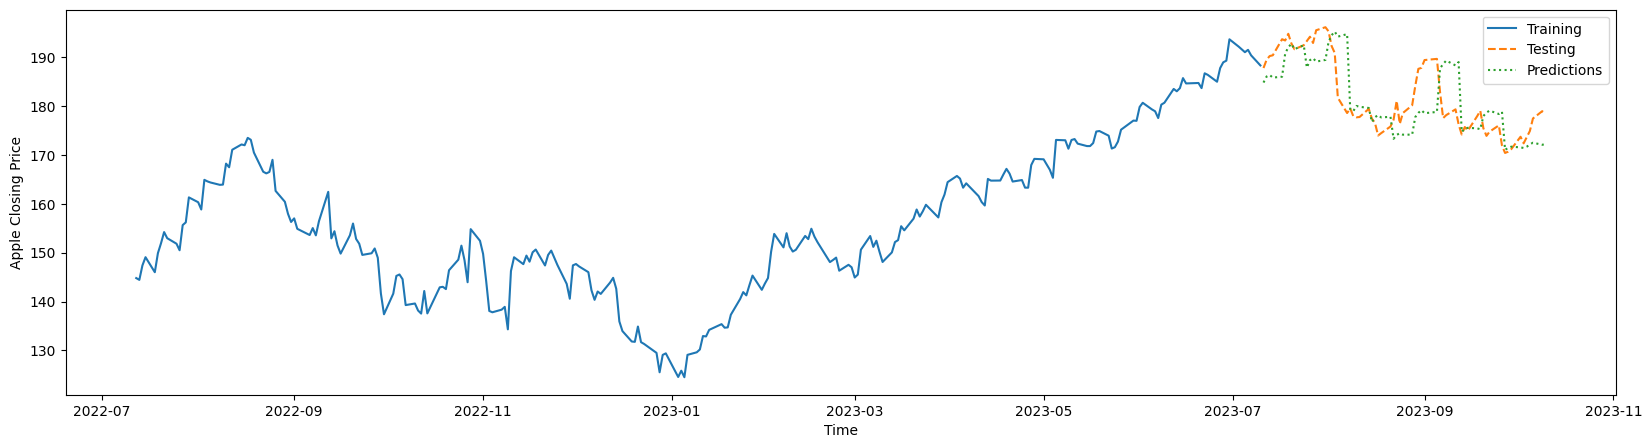

In [54]:
plt.figure(figsize=(20, 5))
plt.plot(APPL['Date'][(APPL['Date'] > '2022-07-11') & (APPL['Date'] < '2023-07-11')], APPL['Adj Close'][(APPL['Date'] > '2022-07-11') & (APPL['Date'] < '2023-07-11')], label = 'Training')
plt.plot(APPL['Date'][APPL['Date'] >= '2023-07-11'], APPL['Adj Close'][APPL['Date'] >= '2023-07-11'], label = 'Testing', linestyle='--')
plt.plot(APPL['Date'][APPL['Date'] >= '2023-07-11'], APPL_prediction.reshape(-1), label = 'Predictions', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Apple Closing Price')
plt.legend(loc = 'best')

In [22]:
rmse = math.sqrt(mean_squared_error(APPL_Test_Y.reshape(-1, 5), APPL_prediction))
mape = np.mean(np.abs(APPL_prediction - APPL_Test_Y.reshape(-1, 5))/np.abs(APPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.673093092470288
MAPE: 0.02387875513178819


#Tesla

In [23]:
TESL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500.0
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500.0
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500.0
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500.0
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500.0


In [24]:
TESL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [25]:
# Change Datatype of tesla's Date column
TESL["Date"] = pd.to_datetime(TESL["Date"])

###Divide the data into training and test set

    Training Period: 2017-01-01 - 2023-07-10

    Testing Period:  2023-07-11 - 2023-10-10

In [26]:
TESL_Train_X, TESL_Train_Y, TESL_Test_X, TESL_Test_Y = get_train_test_xy_data(TESL, divide_by_date)

### Model Fitting

In [27]:
TESL_Model = LSTM_Model()

In [28]:
TESL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [29]:
TESL_hist = TESL_Model.fit(TESL_Train_X, TESL_Train_Y, epochs = 200, validation_data = (TESL_Test_X, TESL_Test_Y), callbacks=[callback])

Epoch 1/200
11/11 [==============================] - 4s 76ms/step - loss: 26193.4023 - root_mean_squared_error: 161.8438 - val_loss: 63761.1680 - val_root_mean_squared_error: 252.5097 - lr: 0.0000e+00
Epoch 2/200
11/11 [==============================] - 0s 34ms/step - loss: 26192.7500 - root_mean_squared_error: 161.8418 - val_loss: 63757.1523 - val_root_mean_squared_error: 252.5018 - lr: 6.6667e-08
Epoch 3/200
11/11 [==============================] - 0s 33ms/step - loss: 26190.3848 - root_mean_squared_error: 161.8344 - val_loss: 63749.1250 - val_root_mean_squared_error: 252.4859 - lr: 1.3333e-07
Epoch 4/200
11/11 [==============================] - 0s 31ms/step - loss: 26186.5332 - root_mean_squared_error: 161.8225 - val_loss: 63736.5195 - val_root_mean_squared_error: 252.4609 - lr: 2.0000e-07
Epoch 5/200
11/11 [==============================] - 1s 48ms/step - loss: 26180.8613 - root_mean_squared_error: 161.8050 - val_loss: 63720.0000 - val_root_mean_squared_error: 252.4282 - lr: 2.6667

In [30]:


TESL_dict_history = TESL_hist.history

data_loss = TESL_dict_history["loss"]
root_mean_squared_error = TESL_dict_history["root_mean_squared_error"]
value_loss = TESL_dict_history["val_loss"]
value_root_mean_squared_error = TESL_dict_history["val_root_mean_squared_error"]

epochs = range(1, len(data_loss) + 1)

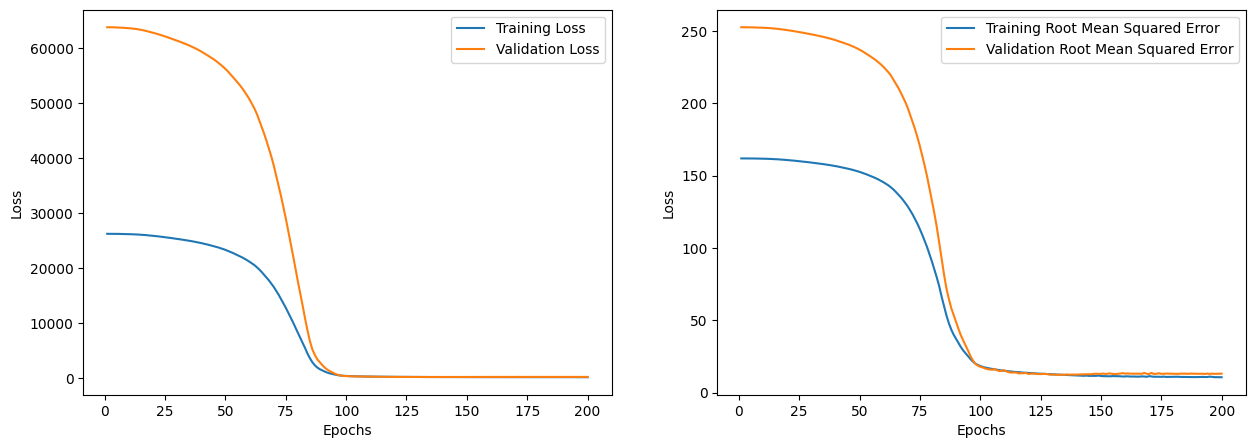

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, data_loss, label = "Training Loss")
ax1.plot(epochs, value_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, value_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Forecasting the final stock price of TESLA

In [32]:
TESL_prediction = TESL_Model.predict(TESL_Test_X)

1/1 [==============================] - 1s 582ms/step


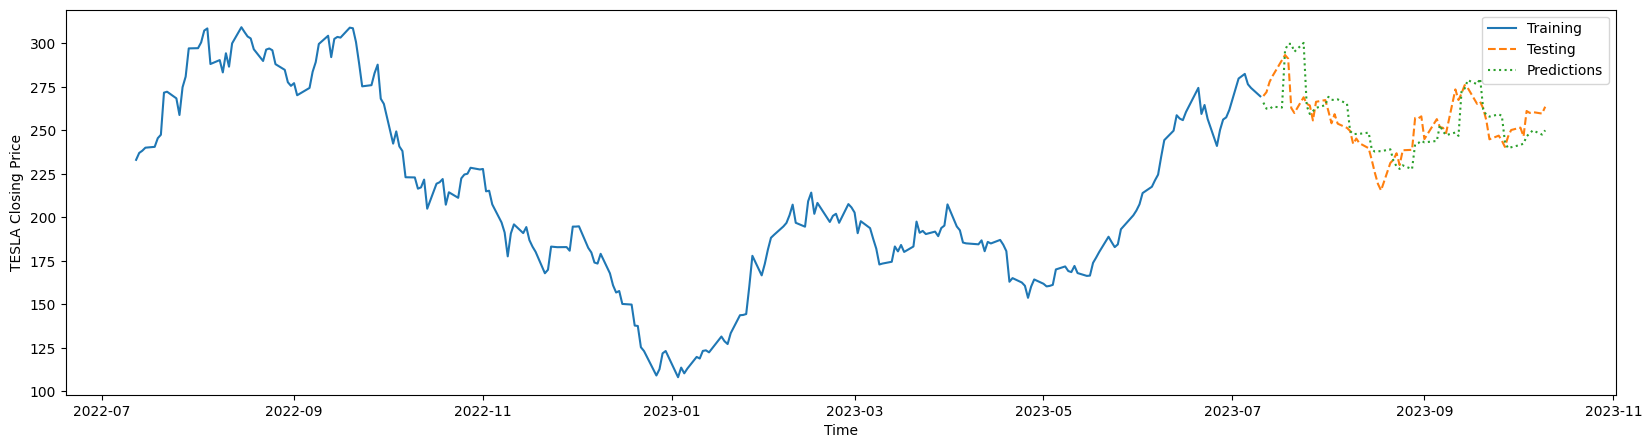

In [55]:
plt.figure(figsize=(20, 5))
plt.plot(TESL['Date'][(TESL['Date'] > '2022-07-11') & (TESL['Date'] < '2023-07-11')], TESL['Adj Close'][(TESL['Date'] > '2022-07-11') & (TESL['Date'] < '2023-07-11')], label = 'Training')
plt.plot(TESL['Date'][TESL['Date'] >= '2023-07-11'], TESL['Adj Close'][TESL['Date'] >= '2023-07-11'], label = 'Testing', linestyle='--')
plt.plot(TESL['Date'][TESL['Date'] >= '2023-07-11'], TESL_prediction.reshape(-1), label = 'Predictions', linestyle=':')
plt.xlabel('Time')
plt.ylabel('TESLA Closing Price')
plt.legend(loc = 'best')

In [34]:
rmse = math.sqrt(mean_squared_error(TESL_Test_Y.reshape(-1, 5), TESL_prediction))
mape = np.mean(np.abs(TESL_prediction - TESL_Test_Y.reshape(-1, 5))/np.abs(TESL_Test_Y.reshape(-1, 5)))
print(f'RMSE of TESLA: {rmse}')
print(f'MAPE of TESLA: {mape}')

RMSE of TESLA: 13.074157200918531
MAPE of TESLA: 0.0399110481269576


#Google

In [35]:
GOOG.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,38.940498,39.481499,38.790001,39.306999,39.306999,33146000.0
1,2017-01-04,39.417999,39.567001,39.158001,39.345001,39.345001,21460000.0
2,2017-01-05,39.304001,39.723999,39.250999,39.701000,39.701000,26704000.0
3,2017-01-06,39.763000,40.395000,39.610199,40.307499,40.307499,32804000.0
4,2017-01-09,40.320000,40.498299,40.141499,40.332500,40.332500,25492000.0


In [36]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [37]:
# Change Datatype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Divide the data into training and test set

    Training Period: 2017-01-01 - 2023-07-10

    Testing Period:  2023-07-11 - 2023-10-10

In [38]:
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = get_train_test_xy_data(GOOG, divide_by_date)

In [39]:
GOOG_Model = LSTM_Model()

In [40]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [41]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 900, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks=[callback])

Epoch 1/900
11/11 [==============================] - 7s 140ms/step - loss: 7667.9175 - root_mean_squared_error: 87.5667 - val_loss: 17388.4023 - val_root_mean_squared_error: 131.8651 - lr: 0.0000e+00
Epoch 2/900
11/11 [==============================] - 0s 34ms/step - loss: 7667.8467 - root_mean_squared_error: 87.5662 - val_loss: 17387.9785 - val_root_mean_squared_error: 131.8635 - lr: 6.6667e-08
Epoch 3/900
11/11 [==============================] - 0s 33ms/step - loss: 7667.6030 - root_mean_squared_error: 87.5648 - val_loss: 17387.0840 - val_root_mean_squared_error: 131.8601 - lr: 1.3333e-07
Epoch 4/900
11/11 [==============================] - 0s 31ms/step - loss: 7667.1655 - root_mean_squared_error: 87.5624 - val_loss: 17385.6582 - val_root_mean_squared_error: 131.8547 - lr: 2.0000e-07
Epoch 5/900
11/11 [==============================] - 0s 33ms/step - loss: 7666.5225 - root_mean_squared_error: 87.5587 - val_loss: 17383.6680 - val_root_mean_squared_error: 131.8472 - lr: 2.6667e-07
Epoc

In [42]:


GOOG_dict_history = GOOG_hist.history

data_loss = GOOG_dict_history["loss"]
root_mean_squared_error = GOOG_dict_history["root_mean_squared_error"]
value_loss = GOOG_dict_history["val_loss"]
value_root_mean_squared_error = GOOG_dict_history["val_root_mean_squared_error"]

epochs = range(1, len(data_loss) + 1)

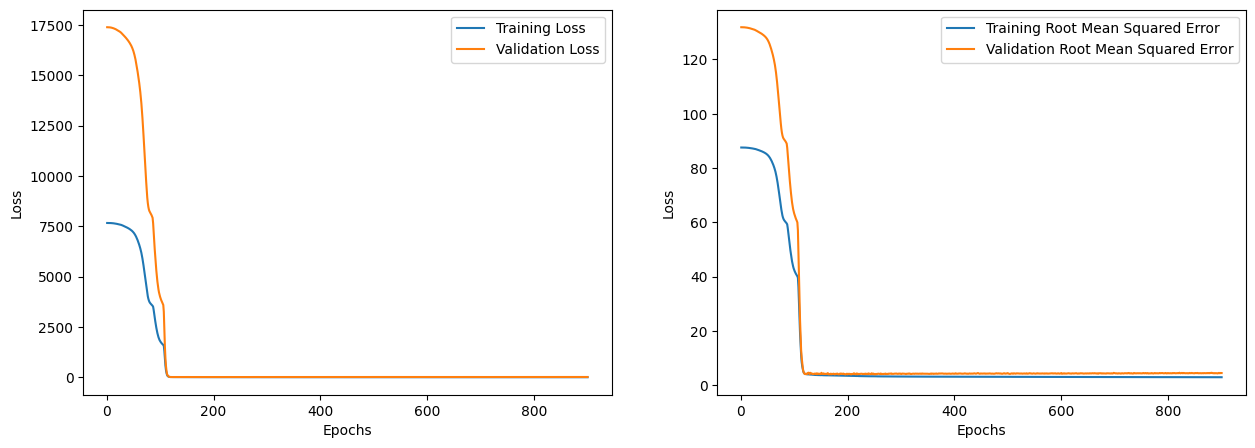

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, data_loss, label = "Training Loss")
ax1.plot(epochs, value_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, value_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Forecasting the final stock price of GOOG

In [44]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

1/1 [==============================] - 1s 515ms/step


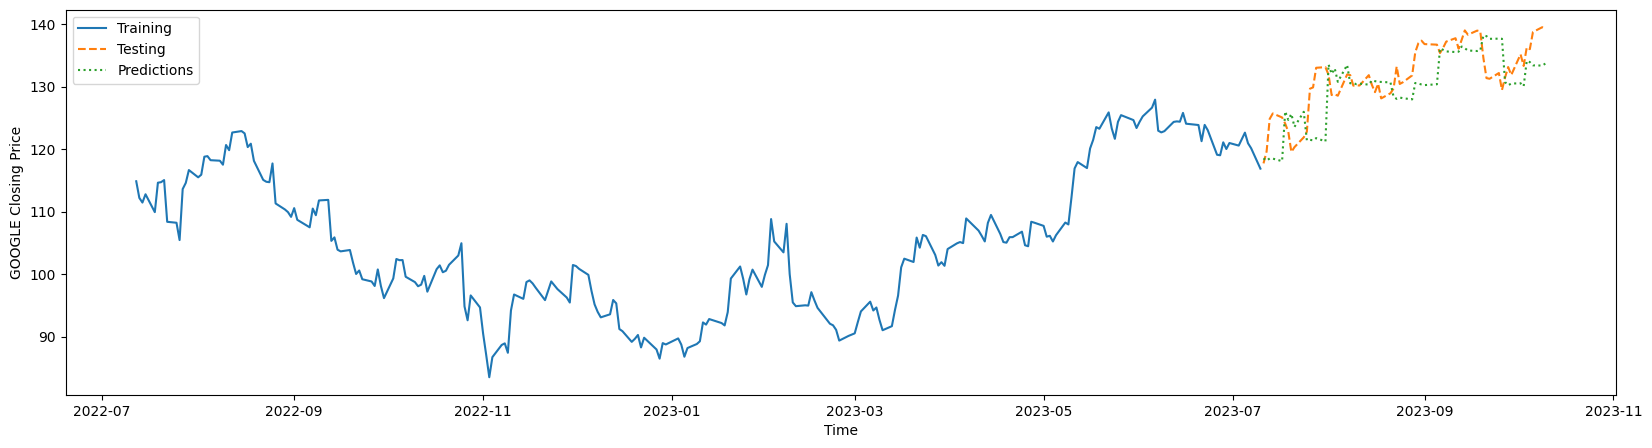

In [56]:
plt.figure(figsize=(20, 5))
plt.plot(GOOG['Date'][(GOOG['Date'] > '2022-07-11') & (GOOG['Date'] < '2023-07-11')], GOOG['Adj Close'][(GOOG['Date'] > '2022-07-11') & (GOOG['Date'] < '2023-07-11')], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2023-07-11'], GOOG['Adj Close'][GOOG['Date'] >= '2023-07-11'], label = 'Testing',linestyle='--')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2023-07-11'], GOOG_prediction.reshape(-1), label = 'Predictions',linestyle=':')
plt.xlabel('Time')
plt.ylabel('GOOGLE Closing Price')
plt.legend(loc = 'best')

In [46]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE of GOOGLE: {rmse}')
print(f'MAPE of GOOGLE: {mape}')

RMSE of GOOGLE: 4.510289511382836
MAPE of GOOGLE: 0.0273563231865537
